# Overall performance of module detection methods

In [2]:
import sys
import os
sys.path.insert(0,os.path.abspath("../lib/"))

import json

from util import JSONExtendedEncoder

from modulecontainers import Modules

%load_ext autoreload
%autoreload 2

%matplotlib inline
from matplotlib.pyplot import *

import pandas as pd
import numpy as np

import multiprocessing as mp

from collections import OrderedDict

from itertools import product
from collections import defaultdict

import itertools
import shutil

conf_folder = "conf/"

from cluster import generate_batchcode
import prism_cluster
import os

import pyperclip as pc

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Running a method on different parameter settings and datasets

The following code will explore the parameters of a module detection method on every dataset using a grid-search approach.

If you want to run your own method, you should wrap it into a python function and add its parameters to `paramexplo_blueprints.py`. We will show the whole workflow here for a "dummy"  (but fast) clustering method, which will simply group genes randomly.

Every module detection method is wrapped in a python function (see lib/moduledetection.py)

Because module detection methods usually take a while to run, we generate the files necessary to run a method on the several parameter settings and datasets here. These can then be easily called from the commandline, for example on a computer cluster or locally using GNU `parallel`.

This function will be called by scripts/moduledetection.py , which will save the modules in the correct format along with additional run information (such as running times).

In [3]:
# datasets to run
datasetnames = ["ecoli_colombos", "ecoli_dream5", "yeast_gpl2529", "yeast_dream5", "synth_ecoli_regulondb", "synth_yeast_macisaac", "human_tcga", "human_gtex", "human_seek_gpl5175"]

# paramexplo_blueprints.py stores for every method the parameters which will be varied using a grid-search approach.
%run ../conf/paramexplo_blueprints.py

# choose the method to evaluate
method_name = "agglom"
methodblueprint = blueprints[method_name]

Generate different parameter settings using a grid-search.

In [4]:
params_folder = "conf/paramexplo/" + method_name + "/"
if os.path.exists("../" + params_folder):
    shutil.rmtree("../" + params_folder)
os.makedirs("../" + params_folder)

methodsettings = []
method_locations = []
i = 0
for dynparam_combination in list(itertools.product(*[methodblueprint["dynparams"][param] for param in sorted(methodblueprint["dynparams"].keys())])):
    method = {"params":{}}
    method["params"] = methodblueprint["staticparams"].copy()
    method["params"].update(dict(zip(sorted(methodblueprint["dynparams"].keys()), dynparam_combination)))
    method["location"] = params_folder + str(i) + ".json"
    method["seed"] = 0

    methodsettings.append(method)

    json.dump(method, open("../" + method["location"], "w"), cls=JSONExtendedEncoder)

    method_locations.append(method["location"])

    i+=1

Now combine the different parameter settings and datasets. Then generate the different python commands to run every parameter setting and dataset in parallel.

In [5]:
if datasetnames[0].startswith("synth"):
    settings_name = "paramexplo/{method_name}_synth".format(method_name = method_name)
elif datasetnames[0].endswith("operon"):
    settings_name = "paramexplo/{method_name}_operon".format(method_name = method_name)
elif len(datasetnames) > 1:
    settings_name = "paramexplo/{method_name}".format(method_name = method_name)
else:
    settings_name = "paramexplo/{method_name}_{datasetname}".format(method_name = method_name, datasetname=datasetnames[0])
settings = [{
        "dataset_location":"conf/datasets/" + datasetname + ".json",
        "dataset_name":datasetname,
        "method_location":methodsetting["location"],
        "output_folder":"results/" + methodblueprint["type"] + "/{settings_name}/{i}/".format(settings_name=settings_name, i=i)
    } for i, (datasetname, methodsetting) in enumerate(product(datasetnames, methodsettings))]
json.dump(settings, open("../conf/settings/{settings_name}.json".format(settings_name=settings_name), "w"))

In [6]:
commands = ""
for i, setting in enumerate(settings):
    #commands += "python scripts/moduledetection.py {method_location} {dataset_location} {output_folder} 0 test\n".format(**setting)
    commands += "python scripts/" + methodblueprint["type"] + ".py {method_location} {dataset_location} {output_folder}\n".format(**setting)

commands_location = "tmp/{settings_name}.txt".format(**locals())
os.makedirs("../" + os.path.dirname(commands_location), exist_ok=True)
with open("../" + commands_location, "w") as outfile:
    outfile.write(commands)
commands_location = "tmp/{settings_name}.txt".format(**locals())
os.makedirs(os.path.dirname("/home/wouters/prism/biclust_comp2/" + commands_location), exist_ok=True)
with open("/home/wouters/prism/biclust_comp2/" + commands_location, "w") as outfile:
    outfile.write(commands)
    
#script_location = generate_batchcode(commands_location, settings_name, len(settings), {"memory":"10G", "numcores":1}, "biclust_comp2")

# this command can be used on most linux computers to run the different parameter settings in parallel
print("parallel -a " + commands_location)

print("sh scripts/{settings_name}.sh".format(**locals()))

pc.copy("parallel -a " + commands_location)

parallel -a tmp/paramexplo/agglom.txt
sh scripts/paramexplo/agglom.sh


# Evaluating the method

## By comparing with known modules

In [1]:
from modulescomparison import ModevalKnownmodules

ImportError: No module named 'modulescomparison'

In [2]:
# create pool of processors
if "pool" in locals().keys():
    pool.close()
pool = mp.Pool(mp.cpu_count()-1)

NameError: name 'mp' is not defined

In [9]:
settings_filtered = [setting for setting in settings if not setting["dataset_name"].startswith("human")]
modeval = ModevalKnownmodules(settings_filtered)
modeval.run(pool)

/usr/local/lib/python3.4/dist-packages/pandas/indexes/base.py:1264: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return getitem(key)


In [14]:
modeval.save(settings_name)

## Using the coverage of regulators

In [172]:
from modulescomparison import ModevalCoverage

In [173]:
# built a pool of processors
if "pool" in locals().keys():
    pool.close()
pool = mp.Pool(mp.cpu_count()-1)

In [174]:
settings_filtered = [setting for setting in settings if setting["dataset_name"].startswith("human")]
modeval = ModevalCoverage(settings_filtered)
modeval.run(pool)

Evaluating a total of 252 settings.


In [176]:
modeval.save(settings_name)

In [177]:
modeval.load(settings_name)

## Comparing with other methods

In [178]:
def score_method(scores):
    methodscores = []
    for ((datasetoiname, knownmodulesoi), scoresoi), ((datasetorname, knownmodulesor), scoresor) in product(scores.groupby(["datasetname", "knownmodules"]), scores.groupby(["datasetname", "knownmodules"])):
        if (datasetorname.split("_")[0]=="synth" and datasetoiname.split("_")[0]!="synth") or (datasetorname.split("_")[0]!="synth" and datasetoiname.split("_")[0]=="synth"):
            continue
                
        # remove 
        if (knownmodulesoi.split("#")[-1] != knownmodulesor.split("#")[-1]):
            if (datasetoiname.startswith("human") != datasetorname.startswith("human")):# and (("minimal" in knownmodulesor) or ("minimal" in knownmodulesoi)):
                ""
            else:
                continue

        # find the most optimal method parameters in the reference dataset (test dataset)
        
        bestparams = scoresor[paramsoi].ix[scoresor["score"].idxmax()]
        
        try:
            rowids = scoresoi.index[np.where(np.all([scoresoi[param] == paramvalue for param, paramvalue in bestparams.items()], 0))[0]]
        except:
            print(scoresoi)

        # now find these parameters in the dataset of interest (training dataset)
        rowids = scoresoi.index[np.where(np.all([scoresoi[param] == paramvalue for param, paramvalue in bestparams.items()], 0))[0]]
            
        if len(rowids) == 0:
            print("parameters could not be matched!!", datasetoiname, datasetorname)
            print(bestparams)
        if len(rowids) > 1:
            print(datasetoiname)
            print("multiple matched parameters")
            print(scoresoi.ix[rowids][paramsoi])

        methodscores.append({
            "datasetoi":datasetoiname,
            "datasetor":datasetorname,
            "score":scoresoi.ix[rowids,"score"].max(),
            "method":methodname,
            "knownmodulesoi":knownmodulesoi,
            "knownmodulesor":knownmodulesor,
            "ofinterest":datasetoiname + "#" + knownmodulesoi,
            "ofreference":datasetorname + "#" + knownmodulesor,
            "runningtime":scoresoi.ix[rowids, "runningtime"].mean() if "runningtime" in scoresoi.columns else 0,
            "goldstandard":scoresoi.ix[rowids, "goldstandard"].tolist()[0],
            "goldstandardoi":scoresoi.ix[rowids, "goldstandard"].tolist()[0],
            "goldstandardor":scoresor["goldstandard"].tolist()[0]
        })
    
    return pd.DataFrame(methodscores)

In [179]:
methodnames = ["dummy", "agglom"]

In [180]:
finalscores = []
for methodname in methodnames:
    print(methodname)
    paramsoi = methodparamsoi[methodname]

    scores = pd.DataFrame()
    
    settings_name = "paramexplo/" + methodname
    modeval = ModevalKnownmodules(settings_name)
    modeval.load(settings_name)
    modeval.scores["score"] = modeval.scores["F1rprr_permuted"]
    modeval.scores["goldstandard"] = [modulesname if modulesname in ["minimal", "strict"] else "interconnected" for modulesname in modeval.scores["knownmodules_name"]]
    modeval.scores["knownmodules"] = modeval.scores["regnet_name"] + "#" + modeval.scores["knownmodules_name"]
    scores = scores.append(modeval.scores, ignore_index=True)
    
    settings_name = "paramexplo/" + methodname
    modeval = ModevalCoverage(settings_name)
    modeval.load(settings_name)
    modeval.scores = modeval.scores.query("binding == 'regcircuit'")
    modeval.scores["score"] = modeval.scores["aucodds_permuted"]
    modeval.scores["goldstandard"] = "regcircuit"
    modeval.scores["knownmodules"] = "regcircuit"
    modeval.scores["binding"] = "regcircuit"
    scores = scores.append(modeval.scores, ignore_index=True)

    scores["organism"] = [dataset.split("_")[0] for dataset in scores["datasetname"]]
    
    methodscores = score_method(scores)
    
    methodscores["organismoi"] = [dataset.split("_")[0] for dataset in methodscores["datasetoi"]]
    methodscores["organismor"] = [dataset.split("_")[0] for dataset in methodscores["datasetor"]]
    
    methodscores["organismnetoi"] = [dataset.split("_")[0] for dataset in methodscores["knownmodulesoi"]]
    methodscores["organismnetor"] = [dataset.split("_")[0] for dataset in methodscores["knownmodulesor"]]

    finalscores.append(methodscores)
finalscores = pd.concat(finalscores, ignore_index=True)

dummy
agglom


In [181]:
def add_weights(scores):
    weights = []
    for organismoi, subscores in scores.groupby("organismoi"):
        goldstandard_weights = 1/subscores.groupby("goldstandard")["score"].count()
        for goldstandard, weight in goldstandard_weights.items():
            weights.append({
                    "organism":organismoi,
                    "goldstandard":goldstandard,
                    "weight":weight / len(goldstandard_weights)
                })
    weights = pd.DataFrame(weights).set_index(["organism", "goldstandard"])["weight"]
    
    scores["weight"] = weights.ix[pd.Index(scores[["organismoi", "goldstandard"]])].tolist()
    
    return scores

In [182]:
trainingscores_ = add_weights(finalscores.ix[(finalscores["ofinterest"] == finalscores["ofreference"])])
testscores_ = add_weights(finalscores.ix[(finalscores["ofinterest"] != finalscores["ofreference"]) & (finalscores["organismnetoi"] != finalscores["organismnetor"])])

trainingscores = trainingscores_.groupby("method").apply(lambda x: np.average(x.score, weights=x.weight))
testscores = testscores_.groupby("method").apply(lambda x: np.average(x.score, weights=x.weight))

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


''

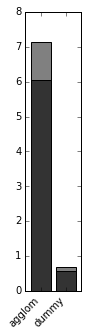

In [191]:
fig, ax = subplots(figsize=(len(trainingscores)/2, 5))

methodorder = testscores.sort_values(ascending=False).index

ax.bar(range(len(methodorder)), trainingscores[methodorder], color="grey")
ax.bar(range(len(methodorder)), testscores[methodorder], color="#333333")
ax.set_xlim(-0.2, len(methodorder))
ax.set_xticks(np.arange(len(methodorder))+0.4)
ax.set_xticklabels(methodorder, rotation=45, ha="right", va="top")
""

In [35]:
methodnames = [
                "baseline_permuted","baseline_sticky","baseline_scalefree",
            "agglom_auto", "kmedoids_auto",
               "qubic", "opsm", "isa", "plaid", "spectral_biclust", "msbe", "fabia", "biforce", "chengchurch",
                "affinity", "flame", "spectral_similarity", "wgcna", "transitivity", "agglom", "divisive", "hybrid",
               "dbscan", "dclust", "kmeans", "kmedoids", "meanshift", "som", "clues","click", "mcl", "sota", 
               "spectral_knn", "cmeans",
              "ica_fdr", "ica_zscore", "ipca", "ica_fdr_signed", "pca",
               "graphclust_genie3", "graphclust_clr", "graphclust_tigress", "graphclust_correlation",
                "genomica", "merlin"
              ]